## 1. MLP

page 61

In [1]:
import sys
sys.path.append("../gluon-tutorials-zh")
import gluonbook as gb
from mxnet import gluon, init, nd
from mxnet.gluon import loss as gloss, nn

%matplotlib inline

/Users/i058959/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def xyplot(x_vals, y_vals, x_label, y_label):
    %config InlineBackend.figure_format = "retina"
    gb.plt.rcParams['figure.figsize'] = (3.5, 2.5)
    gb.plt.plot(x_vals, y_vals)
    gb.plt.xlabel(x_label)
    gb.plt.ylabel(y_label)

In [3]:
x = nd.arange(-5.0, 5.0, 0.1)

### Relu

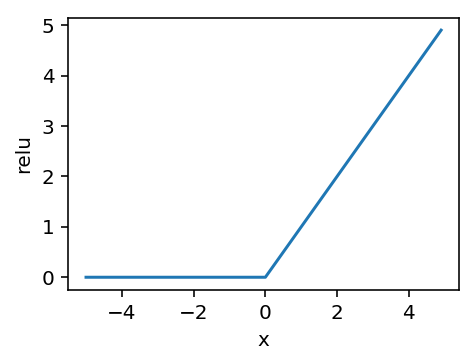

In [4]:
xyplot(x.asnumpy(), x.relu().asnumpy(), 'x', 'relu')

### Sigmoid

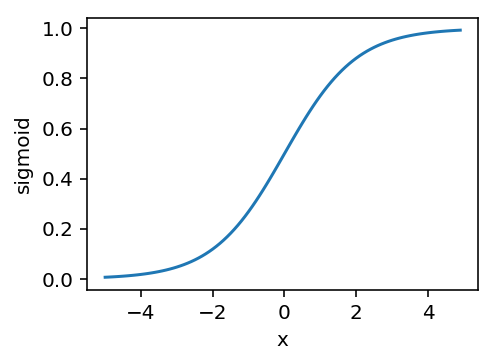

In [5]:
xyplot(x.asnumpy(), x.sigmoid().asnumpy(), 'x', 'sigmoid')

### Tanh

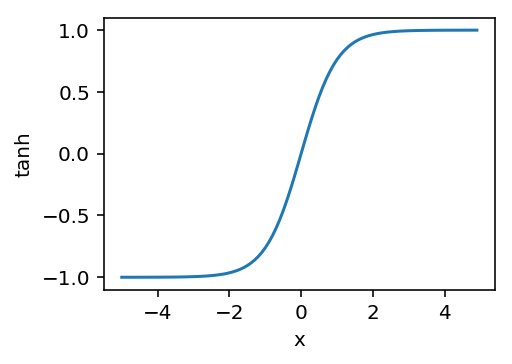

In [6]:
xyplot(x.asnumpy(), x.tanh().asnumpy(), 'x', 'tanh')

## 2. Manual MLP

page 68

In [7]:
from mxnet.gluon import loss as gloss

In [8]:
batch_size = 256
train_iter, test_iter = gb.load_data_fashion_mnist(batch_size)

In [9]:
num_inputs = 784
num_ouputs = 10
num_hiddens = 256

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens))
b1 = nd.zeros(num_hiddens)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens, num_ouputs))
b2 = nd.zeros(num_ouputs)
params = [W1, b1, W2, b2]
for param in params:
    param.attach_grad()

In [10]:
def relu(X):
    """
    manually for max(X, 0)
    """
    return nd.maximum(X, 0)

In [11]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(nd.dot(X, W1) + b1)
    return nd.dot(H, W2) + b2

In [12]:
loss = gloss.SoftmaxCrossEntropyLoss()
num_epochs = 5
lr = 0.5
gb.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.7929, train acc 0.707, test acc 0.826
epoch 2, loss 0.4928, train acc 0.816, test acc 0.849
epoch 3, loss 0.4301, train acc 0.839, test acc 0.858
epoch 4, loss 0.3952, train acc 0.853, test acc 0.868
epoch 5, loss 0.3719, train acc 0.863, test acc 0.875


## 3.  Gluon MLP

page 71

In [13]:
from mxnet import gluon, init
from mxnet.gluon import loss as gloass, nn

In [14]:
net = nn.Sequential()
net.add(nn.Dense(num_hiddens, activation='relu'))
net.add(nn.Dense(num_ouputs))
net.initialize(init.Normal(sigma=0.01))

In [15]:
batch_size = 256
train_iter, test_iter = gb.load_data_fashion_mnist(batch_size)
loss = gloss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
num_epochs = 5
gb.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 2.3036, train acc 0.076, test acc 0.074
epoch 2, loss 2.3036, train acc 0.076, test acc 0.074
epoch 3, loss 2.3036, train acc 0.076, test acc 0.074
epoch 4, loss 2.3036, train acc 0.076, test acc 0.074
epoch 5, loss 2.3036, train acc 0.076, test acc 0.074


## 4. Overfitting, underfitting and Model Selection

### 4.1 Poloynomial fitting experiment

In [16]:
import sys
sys.path.append("../gluon-tutorials-zh")
import gluonbook as gb
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

%matplotlib inline

In [17]:
n_train = 100
n_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = (true_w[0] * poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [18]:
def semilog(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, 
            legend=None, figsize=(3.5, 2.5)):
    gb.set_figsize(figsize)
    gb.plt.xlabel(x_label)
    gb.plt.ylabel(y_label)
    gb.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        gb.plt.semilogy(x2_vals, y2_vals, linestyle=":")
        gb.plt.legend(legend)

In [19]:
num_epochs = 100
loss = gloass.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    print("final epoch: train loss", train_ls[-1], 'test loss', test_ls[-1])
    semilog(range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
            range(1, num_epochs+1), test_ls, ['train', 'test'])
    return ('weight:', net[0].weight.data(), 'loss', net[0].bias.data())

final epoch: train loss 0.009677945 test loss 0.016992046


('weight:', 
 [[ 1.0316063 -3.3147266  5.6500664]]
 <NDArray 1x3 @cpu(0)>, 'loss', 
 [4.8939815]
 <NDArray 1 @cpu(0)>)

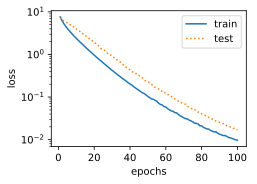

In [20]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

In [21]:
n_train = 100
n_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = (true_w[0] * poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

final epoch: train loss nan test loss nan


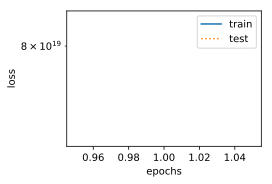

In [22]:
# https://blog.csdn.net/u010824081/article/details/78360476
def linreg(X, w, b): 
    return nd.dot(X, nd.repeat(w, repeats=X.shape[1])) + b

def sgd(params, lr, batch_size): 
    for i, param in enumerate(params):
        param[:] = param - lr * param.grad.mean() / batch_size

# using single w for simulating linear relationship for different feature inputs
w = nd.random.normal(scale=0.01, shape=(1, 1))
b = nd.zeros(shape=(1,))
params = [w, b]
for param in params:
    param.attach_grad()
net = linreg

train_features=poly_features[:n_train, :]; test_features=poly_features[n_train:, :]; train_labels=labels[:n_train]; test_labels=labels[n_train:]

batch_size = min(10, train_labels.shape[0])
train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
train_ls, test_ls = [], []
for _ in range(num_epochs):
    for X, y in train_iter:
        with autograd.record():
            l = loss(net(X, w, b), y)
        l.backward()
        sgd([w, b], lr, batch_size)
    train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
    test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
print("final epoch: train loss", train_ls[-1], 'test loss', test_ls[-1])
semilog(range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
        range(1, num_epochs+1), test_ls, ['train', 'test'])

In [23]:
n_train = 100
n_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = (true_w[0] * poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

final epoch: train loss 8.455938e-06 test loss 8.98363


('weight:', 
 [[ 2.0621903 -1.2865478  5.49603  ]]
 <NDArray 1x3 @cpu(0)>, 'loss', 
 [-0.2933949]
 <NDArray 1 @cpu(0)>)

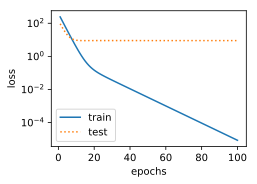

In [24]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

### 4.2 Linear regression for high dimension data

page 81